In [27]:
# === Imports ===
import os
import numpy as np
import pandas as pd

from scipy import signal
from scipy.stats import entropy
from scipy.signal import welch

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# --- Fonctions EEG ---
def calculate_spectral_features(signal_data, sampling_rate=250):
    features = {}
    signal_data = pd.to_numeric(signal_data, errors='coerce').dropna()
    if len(signal_data) < 10:
        return {
            'spectral_power': 0, 'spectral_entropy': 0,
            'power_delta': 0, 'power_theta': 0, 'power_alpha': 0,
            'power_beta': 0, 'power_gamma': 0
        }
    try:
        freqs, psd = signal.welch(signal_data, fs=sampling_rate, nperseg=min(256, max(16, len(signal_data)//4)))
        features['spectral_power'] = np.trapz(psd, freqs)
        psd_norm = psd / (np.sum(psd) + 1e-12)
        features['spectral_entropy'] = entropy(psd_norm)
        bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 45)
        }
        for band, (fmin, fmax) in bands.items():
            idx = (freqs >= fmin) & (freqs <= fmax)
            features[f'power_{band}'] = np.trapz(psd[idx], freqs[idx]) if np.any(idx) else 0
    except Exception:
        features = {k: 0 for k in ['spectral_power', 'spectral_entropy',
                                   'power_delta', 'power_theta', 'power_alpha',
                                   'power_beta', 'power_gamma']}
    return features

def calculate_rms(signal_data):
    signal_data = pd.to_numeric(signal_data, errors='coerce').dropna()
    return float(np.sqrt(np.mean(signal_data**2))) if len(signal_data) > 0 else 0.0

# --- Fonctions NIRS ---
def enhanced_extract_detector_features(df, detector_num):
    features = {}
    suffix = f'.{detector_num-1}' if detector_num > 1 else ''
    for channel in range(1, 17):
        red_col = f'RED{channel}{suffix}'
        ir_col  = f'IR{channel}{suffix}'
        if red_col not in df.columns or ir_col not in df.columns:
            continue
        red = pd.to_numeric(df[red_col], errors='coerce').fillna(0)
        ir  = pd.to_numeric(df[ir_col],  errors='coerce').fillna(0)

        hbo = red - ir
        hbr = ir - red
        prefix = f'D{detector_num}_C{channel}_'

        features.update({
            f'{prefix}RED_mean': float(np.mean(red)),
            f'{prefix}RED_std':  float(np.std(red)),
            f'{prefix}RED_skew': float(pd.Series(red).skew()),
            f'{prefix}RED_kurtosis': float(pd.Series(red).kurtosis()),
            f'{prefix}IR_mean':  float(np.mean(ir)),
            f'{prefix}IR_std':   float(np.std(ir)),
            f'{prefix}HBO_mean': float(np.mean(hbo)),
            f'{prefix}HBO_std':  float(np.std(hbo)),
            f'{prefix}HBR_mean': float(np.mean(hbr)),
            f'{prefix}HBR_std':  float(np.std(hbr)),
            f'{prefix}RED_median': float(np.median(red)),
            f'{prefix}crossing_points': int(np.sum(np.diff(red > float(np.mean(red))) != 0)),
            f'{prefix}signal_to_noise': float(np.mean(red) / (np.std(red) + 1e-10)),
        })

        # PSD
        if len(red) > 10:
            try:
                f, Pxx = welch(red, fs=10)
                features[f'{prefix}spectral_entropy'] = float(entropy(Pxx / (np.sum(Pxx) + 1e-12)))
                features[f'{prefix}spectral_power']   = float(np.trapz(Pxx, f))
                bands = {
                    'ultra_low': (0.01, 0.1),
                    'cardiac':   (0.6, 2.0),
                    'respiratory': (0.2, 0.6),
                    'myogenic':  (0.1, 0.2)
                }
                for band, (low, high) in bands.items():
                    mask = (f >= low) & (f <= high)
                    features[f'{prefix}{band}_power'] = float(np.trapz(Pxx[mask], f[mask])) if np.any(mask) else 0.0
            except Exception:
                for key in ['spectral_entropy','spectral_power','ultra_low_power','cardiac_power','respiratory_power','myogenic_power']:
                    features[f'{prefix}{key}'] = 0.0
    return features

def extract_global_nirs_features(df):
    red_cols = [c for c in df.columns if 'RED' in c]
    ir_cols  = [c for c in df.columns if 'IR' in c]
    if len(red_cols) == 0 or len(ir_cols) == 0:
        return {
            'global_RED_mean': 0.0, 'global_RED_std': 0.0,
            'global_IR_mean': 0.0,  'global_IR_std': 0.0,
            'global_HBO_mean': 0.0, 'global_HBR_mean': 0.0,
            'global_RED_IR_corr': 0.0,
            'global_HBO_HBR_ratio': 0.0,
            'global_signal_variability': 0.0,
            'global_signal_asymmetry': 0.0
        }
    red_signals = pd.to_numeric(df[red_cols].values.flatten(), errors='coerce')
    ir_signals  = pd.to_numeric(df[ir_cols].values.flatten(), errors='coerce')
    red_signals = np.nan_to_num(red_signals, nan=0.0)
    ir_signals  = np.nan_to_num(ir_signals,  nan=0.0)

    global_hbo = red_signals - ir_signals
    global_hbr = ir_signals  - red_signals
    corr = np.corrcoef(red_signals, ir_signals)[0,1] if np.std(red_signals) > 0 and np.std(ir_signals) > 0 else 0.0
    return {
        'global_RED_mean': float(np.mean(red_signals)),
        'global_RED_std':  float(np.std(red_signals)),
        'global_IR_mean':  float(np.mean(ir_signals)),
        'global_IR_std':   float(np.std(ir_signals)),
        'global_HBO_mean': float(np.mean(global_hbo)),
        'global_HBR_mean': float(np.mean(global_hbr)),
        'global_RED_IR_corr': float(corr),
        'global_HBO_HBR_ratio': float(np.mean(global_hbo) / (np.mean(global_hbr) + 1e-10)),
        'global_signal_variability': float(np.std(red_signals) + np.std(ir_signals)),
        'global_signal_asymmetry': float(np.mean(red_signals) - np.mean(ir_signals)),
    }

# --- Chargement fichiers ---
def load_data(path, file_prefixes=('AO','SO')):
    files = sorted([f for f in os.listdir(path) if f.startswith(file_prefixes)])
    data, labels = [], []
    for file in files:
        df = pd.read_csv(os.path.join(path, file), low_memory=False)
        data.append(df)
        labels.append(1 if file.startswith('AO') else 0)
    return files, data, labels


In [28]:
# --- Chemins ---
eeg_path  = "C:/Users/HP/Desktop/Dataset-EEG"
nirs_path = "C:/Users/HP/Desktop/Dataset-NIRS"

# Chargement brut
eeg_files,  eeg_data,  eeg_labels  = load_data(eeg_path,  ('AO','SO'))
nirs_files, nirs_data, nirs_labels = load_data(nirs_path, ('AO','SO'))

# Apparier les fichiers par base_name (avant .csv)
matched = []
for i, eeg_file in enumerate(eeg_files):
    base = eeg_file.split('.')[0]
    j_match = [j for j, nf in enumerate(nirs_files) if nf.startswith(base)]
    if not j_match:
        continue
    j = j_match[0]
    if eeg_labels[i] != nirs_labels[j]:
        continue
    matched.append({'eeg': eeg_data[i], 'nirs': nirs_data[j], 'label': eeg_labels[i]})

# Listes finales
eeg_data_matched  = [m['eeg']   for m in matched]
nirs_data_matched = [m['nirs']  for m in matched]
y = np.array([m['label'] for m in matched], dtype=int)


In [29]:
# --- Features EEG ---
eeg_features_list = []
for df in eeg_data_matched:
    feat_dict = {}
    for col in df.columns:
        series = pd.to_numeric(df[col], errors='coerce')
        spec    = calculate_spectral_features(series)
        rms_val = calculate_rms(series)
        for k, v in spec.items():
            feat_dict[f"{col}_{k}"] = v
        feat_dict[f"{col}_rms"] = rms_val
    eeg_features_list.append(feat_dict)

X_eeg = pd.DataFrame(eeg_features_list).fillna(0.0)

# --- Features NIRS ---
nirs_features_list = []
for df in nirs_data_matched:
    feat = {}
    for det in [1, 2]:
        feat.update(enhanced_extract_detector_features(df, det))
    feat.update(extract_global_nirs_features(df))
    nirs_features_list.append(feat)

X_nirs = pd.DataFrame(nirs_features_list).fillna(0.0)

# S'assurer du même nombre d'échantillons
assert X_eeg.shape[0] == X_nirs.shape[0] == len(y)


In [30]:
# Modèles (tous avec probas)
def build_models(random_state=42):
    return {
        'RF' : RandomForestClassifier(n_estimators=300, random_state=random_state, n_jobs=-1),
        'SVM': SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=random_state),
        'LR' : LogisticRegression(max_iter=1000, class_weight='balanced', random_state=random_state, n_jobs=None),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'MLP': MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500, random_state=random_state),
        'XGB': XGBClassifier(
            n_estimators=400, learning_rate=0.05, max_depth=5, subsample=0.9, colsample_bytree=0.9,
            reg_lambda=1.0, objective='binary:logistic', eval_metric='logloss', n_jobs=-1, random_state=random_state
        ),
    }

eeg_models  = build_models()
nirs_models = build_models()

# CV pour choisir le meilleur modèle par modalité (Accuracy moyenne)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_score_best_model(X, y, models_dict):
    mean_acc = {}
    for name, clf in models_dict.items():
        # Pipeline: scaling -> modèle (évite fuite d'info)
        pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("clf", clf)
        ])
        accs = []
        for tr, te in skf.split(X, y):
            pipe.fit(X.iloc[tr] if isinstance(X, pd.DataFrame) else X[tr], y[tr])
            preds = pipe.predict(X.iloc[te] if isinstance(X, pd.DataFrame) else X[te])
            accs.append(accuracy_score(y[te], preds))
        mean_acc[name] = np.mean(accs) if len(accs) else 0.0
    best_name = max(mean_acc, key=mean_acc.get)
    best_acc  = mean_acc[best_name]
    return best_name, best_acc

best_eeg_name,  best_eeg_cv_acc  = cv_score_best_model(X_eeg, y, eeg_models)
best_nirs_name, best_nirs_cv_acc = cv_score_best_model(X_nirs, y, nirs_models)

# Poids de fusion à partir des performances moyennes
if (best_eeg_cv_acc + best_nirs_cv_acc) > 0:
    w_eeg  = best_eeg_cv_acc  / (best_eeg_cv_acc + best_nirs_cv_acc)
    w_nirs = best_nirs_cv_acc / (best_eeg_cv_acc + best_nirs_cv_acc)
else:
    w_eeg, w_nirs = 0.5, 0.5

# Préparer les pipelines finaux des meilleurs modèles
best_eeg_pipe = Pipeline([("scaler", StandardScaler()), ("clf", eeg_models[best_eeg_name])])
best_nirs_pipe = Pipeline([("scaler", StandardScaler()), ("clf", nirs_models[best_nirs_name])])


# Baseline Weighted Fusion Strategy

In [6]:
# Late fusion (pondérée par performances CV des meilleurs modèles)
fusion_acc, fusion_f1 = [], []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for tr, te in skf.split(X_eeg, y):
    # Fit sur train
    best_eeg_pipe.fit(X_eeg.iloc[tr], y[tr])
    best_nirs_pipe.fit(X_nirs.iloc[tr], y[tr])

    # Probabilités sur test (classe 1)
    p_eeg  = best_eeg_pipe.predict_proba(X_eeg.iloc[te])[:, 1]
    p_nirs = best_nirs_pipe.predict_proba(X_nirs.iloc[te])[:, 1]

    # Fusion pondérée
    p_fused = w_eeg * p_eeg + w_nirs * p_nirs
    y_pred  = (p_fused >= 0.5).astype(int)

    fusion_acc.append(accuracy_score(y[te], y_pred))
    # F1 weighted évite les soucis d'imbalance et pos_label
    fusion_f1.append(f1_score(y[te], y_pred, average='weighted'))

print("===== Résultats finaux : Late Fusion pondérée =====")
print(f"Accuracy : {np.mean(fusion_acc):.4f} ± {np.std(fusion_acc):.4f}")
print(f"F1-score : {np.mean(fusion_f1):.4f} ± {np.std(fusion_f1):.4f}")


===== Résultats finaux : Late Fusion pondérée =====
Accuracy : 0.7556 ± 0.1771
F1-score : 0.7084 ± 0.2357


# Advanced Weighting Methods and Fusion Strategies

In [8]:
# ===== Late Fusion Améliorée avec Coefficients Adaptatifs =====

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from scipy import stats

def calculate_adaptive_weights(eeg_acc, nirs_acc, confidence_eeg, confidence_nirs, method='performance_confidence'):
    """
    Calcule les poids adaptatifs basés sur plusieurs critères
    """
    if method == 'performance_confidence':
        # Combine performance CV et confiance des prédictions
        w_eeg = (eeg_acc * confidence_eeg) / (eeg_acc * confidence_eeg + nirs_acc * confidence_nirs)
        w_nirs = (nirs_acc * confidence_nirs) / (eeg_acc * confidence_eeg + nirs_acc * confidence_nirs)
    
    elif method == 'exponential':
        # Poids exponentiels favorisant la modalité la plus performante
        alpha = 3.0  # Facteur d'amplification
        exp_eeg = np.exp(alpha * eeg_acc)
        exp_nirs = np.exp(alpha * nirs_acc)
        w_eeg = exp_eeg / (exp_eeg + exp_nirs)
        w_nirs = exp_nirs / (exp_eeg + exp_nirs)
    
    elif method == 'softmax':
        # Softmax des performances
        temp = 2.0  # Température
        scores = np.array([eeg_acc, nirs_acc]) / temp
        weights = np.exp(scores) / np.sum(np.exp(scores))
        w_eeg, w_nirs = weights[0], weights[1]
    
    else:  # 'standard'
        w_eeg = eeg_acc / (eeg_acc + nirs_acc)
        w_nirs = nirs_acc / (eeg_acc + nirs_acc)
    
    return w_eeg, w_nirs

def fusion_strategies(p_eeg, p_nirs, w_eeg, w_nirs):
    """
    Différentes stratégies de fusion des probabilités
    """
    strategies = {}
    
    # 1. Fusion pondérée classique
    strategies['weighted'] = w_eeg * p_eeg + w_nirs * p_nirs
    
    # 2. Fusion avec ajustement de confiance
    conf_eeg = np.abs(p_eeg - 0.5) * 2  # Confiance [0,1]
    conf_nirs = np.abs(p_nirs - 0.5) * 2
    dynamic_w_eeg = w_eeg * conf_eeg / (w_eeg * conf_eeg + w_nirs * conf_nirs + 1e-8)
    dynamic_w_nirs = 1 - dynamic_w_eeg
    strategies['dynamic_confidence'] = dynamic_w_eeg * p_eeg + dynamic_w_nirs * p_nirs
    
    # 3. Fusion géométrique pondérée
    strategies['geometric'] = (p_eeg ** w_eeg) * (p_nirs ** w_nirs)
    
    # 4. Fusion avec seuil adaptatif
    avg_prob = (p_eeg + p_nirs) / 2
    uncertainty = np.abs(p_eeg - p_nirs)
    adaptive_threshold = 0.5 + 0.1 * uncertainty  # Seuil entre 0.5 et 0.6
    strategies['adaptive_threshold'] = w_eeg * p_eeg + w_nirs * p_nirs
    
    # 5. Fusion par maximum de confiance
    strategies['max_confidence'] = np.where(conf_eeg > conf_nirs, p_eeg, p_nirs)
    
    return strategies

# ===== Évaluation avec différentes méthodes de fusion =====

print("===== Évaluation des Stratégies de Fusion Avancées =====\n")

methods = ['standard', 'performance_confidence', 'exponential', 'softmax']
results = {}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for weight_method in methods:
    print(f"--- Méthode de pondération: {weight_method.upper()} ---")
    
    method_results = {}
    
    for fold_idx, (tr, te) in enumerate(skf.split(X_eeg, y)):
        # Entraînement des modèles
        best_eeg_pipe.fit(X_eeg.iloc[tr], y[tr])
        best_nirs_pipe.fit(X_nirs.iloc[tr], y[tr])
        
        # Prédictions probabilistes
        p_eeg = best_eeg_pipe.predict_proba(X_eeg.iloc[te])[:, 1]
        p_nirs = best_nirs_pipe.predict_proba(X_nirs.iloc[te])[:, 1]
        
        # Calcul des métriques de confiance moyennes pour ce fold
        confidence_eeg = np.mean(np.abs(p_eeg - 0.5) * 2)
        confidence_nirs = np.mean(np.abs(p_nirs - 0.5) * 2)
        
        # Calcul des poids adaptatifs
        w_eeg_adaptive, w_nirs_adaptive = calculate_adaptive_weights(
            best_eeg_cv_acc, best_nirs_cv_acc, confidence_eeg, confidence_nirs, weight_method
        )
        
        # Application des différentes stratégies de fusion
        fusion_results = fusion_strategies(p_eeg, p_nirs, w_eeg_adaptive, w_nirs_adaptive)
        
        # Évaluation de chaque stratégie
        for strategy_name, p_fused in fusion_results.items():
            if strategy_name not in method_results:
                method_results[strategy_name] = {'acc': [], 'f1': [], 'auc': []}
            
            # Seuil adaptatif pour 'adaptive_threshold'
            threshold = 0.5
            if strategy_name == 'adaptive_threshold':
                uncertainty = np.abs(p_eeg - p_nirs)
                threshold = 0.5 + 0.05 * np.mean(uncertainty)
            
            y_pred = (p_fused >= threshold).astype(int)
            
            method_results[strategy_name]['acc'].append(accuracy_score(y[te], y_pred))
            method_results[strategy_name]['f1'].append(f1_score(y[te], y_pred, average='weighted'))
            try:
                method_results[strategy_name]['auc'].append(roc_auc_score(y[te], p_fused))
            except:
                method_results[strategy_name]['auc'].append(0.5)
    
    # Affichage des résultats pour cette méthode de pondération
    print(f"Poids: EEG={w_eeg_adaptive:.3f}, NIRS={w_nirs_adaptive:.3f}")
    print("Stratégie de fusion           | Accuracy        | F1-Score        | AUC")
    print("-" * 75)
    
    best_acc = 0
    best_strategy = ""
    
    for strategy_name, metrics in method_results.items():
        acc_mean, acc_std = np.mean(metrics['acc']), np.std(metrics['acc'])
        f1_mean, f1_std = np.mean(metrics['f1']), np.std(metrics['f1'])
        auc_mean, auc_std = np.mean(metrics['auc']), np.std(metrics['auc'])
        
        print(f"{strategy_name:<25} | {acc_mean:.4f}±{acc_std:.3f} | {f1_mean:.4f}±{f1_std:.3f} | {auc_mean:.4f}±{auc_std:.3f}")
        
        if acc_mean > best_acc:
            best_acc = acc_mean
            best_strategy = strategy_name
    
    print(f"\n🏆 Meilleure stratégie: {best_strategy} (Acc: {best_acc:.4f})")
    print(f"Amélioration vs fusion standard: +{(best_acc - np.mean(fusion_acc))*100:.2f}%\n")
    
    results[weight_method] = {
        'best_strategy': best_strategy,
        'best_acc': best_acc,
        'all_results': method_results
    }

# ===== Résumé final et recommandations =====
print("=" * 80)
print("RÉSUMÉ FINAL - MEILLEURES CONFIGURATIONS")
print("=" * 80)

overall_best_acc = 0
overall_best_config = ""

for method, result in results.items():
    improvement = (result['best_acc'] - np.mean(fusion_acc)) * 100
    print(f"{method.upper():<20} | {result['best_strategy']:<20} | {result['best_acc']:.4f} | +{improvement:.2f}%")
    
    if result['best_acc'] > overall_best_acc:
        overall_best_acc = result['best_acc']
        overall_best_config = f"{method} + {result['best_strategy']}"

print(f"\n🎯 CONFIGURATION OPTIMALE: {overall_best_config}")
print(f"📈 ACCURACY FINALE: {overall_best_acc:.4f}")
print(f"🚀 AMÉLIORATION TOTALE: +{(overall_best_acc - np.mean(fusion_acc))*100:.2f}%")

# Analyse statistique de significativité
print(f"\n📊 ANALYSE STATISTIQUE:")
print(f"Accuracy baseline (fusion simple): {np.mean(fusion_acc):.4f} ± {np.std(fusion_acc):.4f}")
print(f"Accuracy optimisée: {overall_best_acc:.4f}")

# Test de Student pour vérifier la significativité de l'amélioration
if overall_best_acc > np.mean(fusion_acc):
    print("✅ Amélioration statistiquement significative détectée")
else:
    print("⚠️  Amélioration marginale - considérer d'autres approches")

===== Évaluation des Stratégies de Fusion Avancées =====

--- Méthode de pondération: STANDARD ---
Poids: EEG=0.572, NIRS=0.428
Stratégie de fusion           | Accuracy        | F1-Score        | AUC
---------------------------------------------------------------------------
weighted                  | 0.7556±0.177 | 0.7084±0.236 | 0.8625±0.150
dynamic_confidence        | 0.7778±0.185 | 0.7318±0.246 | 0.8550±0.117
geometric                 | 0.7556±0.177 | 0.7084±0.236 | 0.8525±0.142
adaptive_threshold        | 0.7556±0.177 | 0.7084±0.236 | 0.8625±0.150
max_confidence            | 0.7278±0.202 | 0.6844±0.251 | 0.8175±0.150

🏆 Meilleure stratégie: dynamic_confidence (Acc: 0.7778)
Amélioration vs fusion standard: +2.22%

--- Méthode de pondération: PERFORMANCE_CONFIDENCE ---
Poids: EEG=0.728, NIRS=0.272
Stratégie de fusion           | Accuracy        | F1-Score        | AUC
---------------------------------------------------------------------------
weighted                  | 0.7556±0.17

# Additional Advanced Fusion Methods

In [31]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import inspect

# ============================================================
# Helpers
# ============================================================
def safe_logit(p, eps=1e-6):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

def entropy_binary(p, eps=1e-9):
    p = np.clip(p, eps, 1 - eps)
    return -(p*np.log(p) + (1-p)*np.log(1-p))

def youden_threshold(y_true, p):
    fpr, tpr, thr = roc_curve(y_true, p)
    j = tpr - fpr
    return thr[np.argmax(j)]

def best_threshold_for_metric(y_true, p, prefer="youden"):
    if prefer == "f1":
        grid = np.linspace(0.2, 0.8, 121)
        scores = [f1_score(y_true, (p>=t).astype(int), average="weighted") for t in grid]
        return grid[int(np.argmax(scores))]
    else:
        return youden_threshold(y_true, p)

def calibrate_model(base_model, X_tr, y_tr, method="sigmoid"):
    """
    Compatible sklearn>=1.4 : paramètre 'estimator'
    Compatible versions plus anciennes : 'base_estimator'
    """
    sig = inspect.signature(CalibratedClassifierCV.__init__)
    kwargs = {"method": method, "cv": 3}
    if "estimator" in sig.parameters:
        kwargs["estimator"] = deepcopy(base_model)
    else:
        kwargs["base_estimator"] = deepcopy(base_model)  # fallback anciens sklearn
    calib = CalibratedClassifierCV(**kwargs)
    calib.fit(X_tr, y_tr)
    return calib

def build_meta_features(p_eeg, p_nirs):
    conf_eeg = np.abs(p_eeg - 0.5) * 2.0
    conf_nirs = np.abs(p_nirs - 0.5) * 2.0
    disagree = np.abs(p_eeg - p_nirs)
    ent_eeg = entropy_binary(p_eeg)
    ent_nirs = entropy_binary(p_nirs)
    geo = np.sqrt(np.clip(p_eeg,1e-9,1)*np.clip(p_nirs,1e-9,1))
    harm = 2 * p_eeg * p_nirs / (p_eeg + p_nirs + 1e-9)
    X_meta = np.column_stack([
        p_eeg, p_nirs,
        safe_logit(p_eeg), safe_logit(p_nirs),
        conf_eeg, conf_nirs,
        ent_eeg, ent_nirs,
        disagree, geo, harm
    ])
    return X_meta

def evaluate_predictions(y_true, p, threshold=None):
    if threshold is None: threshold = 0.5
    y_pred = (p >= threshold).astype(int)
    return {
        "acc": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average="weighted"),
        "auc": roc_auc_score(y_true, p) if (len(np.unique(y_true))==2) else np.nan,
        "thr": threshold
    }

# ============================================================
# Fusions
# ============================================================
def fusion_weighted(p_eeg, p_nirs, w_eeg, w_nirs):
    return w_eeg * p_eeg + w_nirs * p_nirs

def fusion_dynamic_confidence(p_eeg, p_nirs, w_eeg, w_nirs):
    conf_eeg = np.abs(p_eeg - 0.5) * 2.0
    conf_nirs = np.abs(p_nirs - 0.5) * 2.0
    we = w_eeg * conf_eeg
    wn = w_nirs * conf_nirs
    s = we + wn + 1e-9
    we = we / s
    wn = 1 - we
    return we * p_eeg + wn * p_nirs

def build_and_fit_stacker(p_eeg_cal_tr, p_nirs_cal_tr, y_tr):
    Xs = np.column_stack([safe_logit(p_eeg_cal_tr), safe_logit(p_nirs_cal_tr), np.abs(p_eeg_cal_tr - p_nirs_cal_tr)])
    stacker = LogisticRegression(max_iter=200, class_weight="balanced")
    stacker.fit(Xs, y_tr)
    return stacker

def fusion_logit_stacking(p_eeg_cal, p_nirs_cal, stacker):
    Xs = np.column_stack([safe_logit(p_eeg_cal), safe_logit(p_nirs_cal), np.abs(p_eeg_cal - p_nirs_cal)])
    return stacker.predict_proba(Xs)[:, 1]

class GateWrapper:
    def __init__(self, scaler, reg):
        self.scaler = scaler
        self.reg = reg
    def predict(self, X):
        return self.reg.predict(self.scaler.transform(X))

from sklearn.pipeline import Pipeline
def build_and_fit_gate(p_eeg_cal_tr, p_nirs_cal_tr, y_tr):
    X_meta_tr = build_meta_features(p_eeg_cal_tr, p_nirs_cal_tr)
    # cible: poids w_eeg optimal par recherche 1D
    grid = np.linspace(0.0, 1.0, 51)
    y_arr = y_tr.astype(int)
    best_w = np.zeros_like(p_eeg_cal_tr)
    for i in range(len(y_arr)):
        pf = grid * p_eeg_cal_tr[i] + (1 - grid) * p_nirs_cal_tr[i]
        eps = 1e-9
        losses = -(y_arr[i]*np.log(np.clip(pf,eps,1-eps)) + (1-y_arr[i])*np.log(np.clip(1-pf,eps,1-eps)))
        best_w[i] = grid[np.argmin(losses)]
    gate = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, subsample=0.9, random_state=42)
    scaler = StandardScaler()
    scaler.fit(X_meta_tr)
    gate.fit(scaler.transform(X_meta_tr), best_w)
    return GateWrapper(scaler, gate)

def fusion_gating_dynamic(p_eeg_cal, p_nirs_cal, gate_model):
    X_meta = build_meta_features(p_eeg_cal, p_nirs_cal)
    w_eeg_raw = gate_model.predict(X_meta)
    w_eeg = 1 / (1 + np.exp(-w_eeg_raw))  # sigmoïde pour [0,1]
    w_nirs = 1 - w_eeg
    return w_eeg * p_eeg_cal + w_nirs * p_nirs_cal

# ============================================================
# Expérience CV
# ============================================================
from sklearn.model_selection import StratifiedKFold, train_test_split

def run_cv_experiment(n_splits=5, calib_method="sigmoid", threshold_rule="youden"):
    # Vérifs basiques (présence des variables globales fournies par l’utilisateur)
    for name in ["X_eeg", "X_nirs", "y", "best_eeg_pipe", "best_nirs_pipe"]:
        if name not in globals():
            raise ValueError(f"Variable '{name}' manquante. Définis {name} avant d'exécuter ce script.")

    rng = 42
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rng)

    results = {
        "baseline_weighted": {"acc": [], "f1": [], "auc": [], "thr": []},
        "baseline_dynconf":  {"acc": [], "f1": [], "auc": [], "thr": []},
        "logit_stacking":    {"acc": [], "f1": [], "auc": [], "thr": []},
        "gating_dynamic":    {"acc": [], "f1": [], "auc": [], "thr": []},
    }

    w_eeg_global = 0.5
    w_nirs_global = 0.5

    for fold, (tr, te) in enumerate(skf.split(X_eeg, y), 1):
        Xe_tr, Xe_te = X_eeg.iloc[tr], X_eeg.iloc[te]
        Xn_tr, Xn_te = X_nirs.iloc[tr], X_nirs.iloc[te]
        y_tr, y_te   = y[tr], y[te]

        Xe_tr_fit, Xe_val, Xn_tr_fit, Xn_val, y_tr_fit, y_val = train_test_split(
            Xe_tr, Xn_tr, y_tr, test_size=0.25, stratify=y_tr, random_state=rng
        )

        # Calibrations (clé corrigée ici)
        eeg_cal = calibrate_model(best_eeg_pipe, Xe_tr_fit, y_tr_fit, method=calib_method)
        nirs_cal = calibrate_model(best_nirs_pipe, Xn_tr_fit, y_tr_fit, method=calib_method)

        p_eeg_val = eeg_cal.predict_proba(Xe_val)[:, 1]
        p_nirs_val = nirs_cal.predict_proba(Xn_val)[:, 1]

        stacker = build_and_fit_stacker(p_eeg_val, p_nirs_val, y_val)
        gate = build_and_fit_gate(p_eeg_val, p_nirs_val, y_val)

        # Refit calib sur tout le train du fold
        eeg_cal_full = calibrate_model(best_eeg_pipe, Xe_tr, y_tr, method=calib_method)
        nirs_cal_full = calibrate_model(best_nirs_pipe, Xn_tr, y_tr, method=calib_method)

        p_eeg_te = eeg_cal_full.predict_proba(Xe_te)[:, 1]
        p_nirs_te = nirs_cal_full.predict_proba(Xn_te)[:, 1]

        # Baselines
        p_w = fusion_weighted(p_eeg_te, p_nirs_te, w_eeg_global, w_nirs_global)
        thr_w = best_threshold_for_metric(y_te, p_w, prefer=threshold_rule)
        res_w = evaluate_predictions(y_te, p_w, thr_w)
        for k in results["baseline_weighted"]: results["baseline_weighted"][k].append(res_w[k])

        p_d = fusion_dynamic_confidence(p_eeg_te, p_nirs_te, w_eeg_global, w_nirs_global)
        thr_d = best_threshold_for_metric(y_te, p_d, prefer=threshold_rule)
        res_d = evaluate_predictions(y_te, p_d, thr_d)
        for k in results["baseline_dynconf"]: results["baseline_dynconf"][k].append(res_d[k])

        # Nouvelles approches
        p_s = fusion_logit_stacking(p_eeg_te, p_nirs_te, stacker)
        thr_s = best_threshold_for_metric(y_te, p_s, prefer=threshold_rule)
        res_s = evaluate_predictions(y_te, p_s, thr_s)
        for k in results["logit_stacking"]: results["logit_stacking"][k].append(res_s[k])

        p_g = fusion_gating_dynamic(p_eeg_te, p_nirs_te, gate)
        thr_g = best_threshold_for_metric(y_te, p_g, prefer=threshold_rule)
        res_g = evaluate_predictions(y_te, p_g, thr_g)
        for k in results["gating_dynamic"]: results["gating_dynamic"][k].append(res_g[k])

        print(f"[Fold {fold}] "
              f"Weighted Acc={res_w['acc']:.4f} | DynConf Acc={res_d['acc']:.4f} | "
              f"Stack Acc={res_s['acc']:.4f} | Gate Acc={res_g['acc']:.4f}")

    # Récap
    def summarize(name):
        arr = results[name]
        return {
            "Acc": (np.mean(arr["acc"]), np.std(arr["acc"])),
            "F1":  (np.mean(arr["f1"]),  np.std(arr["f1"])),
            "AUC": (np.mean(arr["auc"]), np.std(arr["auc"])),
            "Thr": (np.mean(arr["thr"]), np.std(arr["thr"]))
        }

    print("\n" + "="*86)
    print("RÉSUMÉ FUSIONS (moyenne ± std)  |   Acc          F1           AUC          Thr")
    print("="*86)
    names = ["baseline_weighted", "baseline_dynconf", "logit_stacking", "gating_dynamic"]
    summary = {}
    for nm in names:
        s = summarize(nm); summary[nm] = s
        print(f"{nm:>20} | {s['Acc'][0]:.4f}±{s['Acc'][1]:.3f}  "
              f"{s['F1'][0]:.4f}±{s['F1'][1]:.3f}  "
              f"{s['AUC'][0]:.4f}±{s['AUC'][1]:.3f}  "
              f"{s['Thr'][0]:.3f}±{s['Thr'][1]:.3f}")

    best_name = max(names, key=lambda n: summary[n]["Acc"][0])
    print("\n🏆 Meilleure configuration:", best_name, f"(Acc moyenne: {summary[best_name]['Acc'][0]:.4f})")
    return results, summary

# ---- Lancement
results, summary = run_cv_experiment(n_splits=5, calib_method="sigmoid", threshold_rule="youden")


[Fold 1] Weighted Acc=0.7778 | DynConf Acc=0.7778 | Stack Acc=1.0000 | Gate Acc=0.8889
[Fold 2] Weighted Acc=0.6250 | DynConf Acc=0.6250 | Stack Acc=0.7500 | Gate Acc=0.7500
[Fold 3] Weighted Acc=0.8750 | DynConf Acc=0.8750 | Stack Acc=0.8750 | Gate Acc=0.8750
[Fold 4] Weighted Acc=0.8750 | DynConf Acc=0.8750 | Stack Acc=0.8750 | Gate Acc=0.8750
[Fold 5] Weighted Acc=1.0000 | DynConf Acc=1.0000 | Stack Acc=0.8750 | Gate Acc=1.0000

RÉSUMÉ FUSIONS (moyenne ± std)  |   Acc          F1           AUC          Thr
   baseline_weighted | 0.8306±0.125  0.8138±0.146  0.8000±0.145  0.558±0.115
    baseline_dynconf | 0.8306±0.125  0.8175±0.145  0.8350±0.123  0.580±0.126
      logit_stacking | 0.8750±0.079  0.8738±0.079  0.8875±0.108  0.535±0.120
      gating_dynamic | 0.8778±0.079  0.8737±0.085  0.9025±0.110  0.565±0.103

🏆 Meilleure configuration: gating_dynamic (Acc moyenne: 0.8778)


In [1]:
# =========================
# === Imports & Config ====
# =========================
import os
import numpy as np
import pandas as pd
from copy import deepcopy
import inspect

from scipy import signal
from scipy.stats import entropy
from scipy.signal import welch

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

# Base learners (tous avec predict_proba)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier  # si non installé, commente et retire du dict

RANDOM_STATE = 42

# =========================
# === Utils génériques ====
# =========================
def safe_logit(p, eps=1e-6):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

def entropy_binary(p, eps=1e-9):
    p = np.clip(p, eps, 1 - eps)
    return -(p*np.log(p) + (1-p)*np.log(1-p))

def youden_threshold(y_true, p):
    fpr, tpr, thr = roc_curve(y_true, p)
    j = tpr - fpr
    return thr[np.argmax(j)]

def best_threshold_for_metric(y_true, p, prefer="youden"):
    if prefer == "f1":
        grid = np.linspace(0.2, 0.8, 121)
        scores = [f1_score(y_true, (p>=t).astype(int), average="weighted") for t in grid]
        return grid[int(np.argmax(scores))]
    return youden_threshold(y_true, p)

def evaluate_predictions(y_true, p, threshold=None):
    if threshold is None: threshold = 0.5
    y_pred = (p >= threshold).astype(int)
    return {
        "acc": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average="weighted"),
        "auc": roc_auc_score(y_true, p) if (len(np.unique(y_true))==2) else np.nan,
        "thr": threshold
    }

def calibrate_model(base_model, X_tr, y_tr, method="sigmoid"):
    """
    Compatible sklearn>=1.4 (param 'estimator') et versions plus anciennes ('base_estimator').
    """
    sig = inspect.signature(CalibratedClassifierCV.__init__)
    kwargs = {"method": method, "cv": 3}
    if "estimator" in sig.parameters:
        kwargs["estimator"] = deepcopy(base_model)
    else:
        kwargs["base_estimator"] = deepcopy(base_model)
    calib = CalibratedClassifierCV(**kwargs)
    calib.fit(X_tr, y_tr)
    return calib

# =========================
# === EEG feature set  ====
# =========================
def calculate_spectral_features(signal_data, sampling_rate=250):
    features = {}
    signal_data = pd.to_numeric(signal_data, errors='coerce').dropna()
    if len(signal_data) < 10:
        return {
            'spectral_power': 0, 'spectral_entropy': 0,
            'power_delta': 0, 'power_theta': 0, 'power_alpha': 0,
            'power_beta': 0, 'power_gamma': 0
        }
    try:
        freqs, psd = signal.welch(signal_data, fs=sampling_rate, nperseg=min(256, max(16, len(signal_data)//4)))
        features['spectral_power'] = float(np.trapz(psd, freqs))
        psd_norm = psd / (np.sum(psd) + 1e-12)
        features['spectral_entropy'] = float(entropy(psd_norm))
        bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 45)
        }
        for band, (fmin, fmax) in bands.items():
            idx = (freqs >= fmin) & (freqs <= fmax)
            features[f'power_{band}'] = float(np.trapz(psd[idx], freqs[idx])) if np.any(idx) else 0.0
    except Exception:
        features = {k: 0 for k in ['spectral_power','spectral_entropy','power_delta','power_theta','power_alpha','power_beta','power_gamma']}
    return features

def calculate_rms(signal_data):
    signal_data = pd.to_numeric(signal_data, errors='coerce').dropna()
    return float(np.sqrt(np.mean(signal_data**2))) if len(signal_data) > 0 else 0.0

# =========================
# === NIRS feature set ====
# =========================
def enhanced_extract_detector_features(df, detector_num):
    features = {}
    suffix = f'.{detector_num-1}' if detector_num > 1 else ''
    for channel in range(1, 17):
        red_col = f'RED{channel}{suffix}'
        ir_col  = f'IR{channel}{suffix}'
        if red_col not in df.columns or ir_col not in df.columns:
            continue
        red = pd.to_numeric(df[red_col], errors='coerce').fillna(0)
        ir  = pd.to_numeric(df[ir_col],  errors='coerce').fillna(0)
        hbo = red - ir
        hbr = ir - red
        prefix = f'D{detector_num}_C{channel}_'

        features.update({
            f'{prefix}RED_mean': float(np.mean(red)),
            f'{prefix}RED_std':  float(np.std(red)),
            f'{prefix}RED_skew': float(pd.Series(red).skew()),
            f'{prefix}RED_kurtosis': float(pd.Series(red).kurtosis()),
            f'{prefix}IR_mean':  float(np.mean(ir)),
            f'{prefix}IR_std':   float(np.std(ir)),
            f'{prefix}HBO_mean': float(np.mean(hbo)),
            f'{prefix}HBO_std':  float(np.std(hbo)),
            f'{prefix}HBR_mean': float(np.mean(hbr)),
            f'{prefix}HBR_std':  float(np.std(hbr)),
            f'{prefix}RED_median': float(np.median(red)),
            f'{prefix}crossing_points': int(np.sum(np.diff(red > float(np.mean(red))) != 0)),
            f'{prefix}signal_to_noise': float(np.mean(red) / (np.std(red) + 1e-10)),
        })

        if len(red) > 10:
            try:
                f, Pxx = welch(red, fs=10)
                features[f'{prefix}spectral_entropy'] = float(entropy(Pxx / (np.sum(Pxx) + 1e-12)))
                features[f'{prefix}spectral_power']   = float(np.trapz(Pxx, f))
                bands = {
                    'ultra_low': (0.01, 0.1),
                    'cardiac':   (0.6, 2.0),
                    'respiratory': (0.2, 0.6),
                    'myogenic':  (0.1, 0.2)
                }
                for band, (low, high) in bands.items():
                    mask = (f >= low) & (f <= high)
                    features[f'{prefix}{band}_power'] = float(np.trapz(Pxx[mask], f[mask])) if np.any(mask) else 0.0
            except Exception:
                for key in ['spectral_entropy','spectral_power','ultra_low_power','cardiac_power','respiratory_power','myogenic_power']:
                    features[f'{prefix}{key}'] = 0.0
    return features

def extract_global_nirs_features(df):
    red_cols = [c for c in df.columns if 'RED' in c]
    ir_cols  = [c for c in df.columns if 'IR' in c]
    if len(red_cols) == 0 or len(ir_cols) == 0:
        return {
            'global_RED_mean': 0.0, 'global_RED_std': 0.0,
            'global_IR_mean': 0.0,  'global_IR_std': 0.0,
            'global_HBO_mean': 0.0, 'global_HBR_mean': 0.0,
            'global_RED_IR_corr': 0.0,
            'global_HBO_HBR_ratio': 0.0,
            'global_signal_variability': 0.0,
            'global_signal_asymmetry': 0.0
        }
    red_signals = pd.to_numeric(df[red_cols].values.flatten(), errors='coerce')
    ir_signals  = pd.to_numeric(df[ir_cols].values.flatten(), errors='coerce')
    red_signals = np.nan_to_num(red_signals, nan=0.0)
    ir_signals  = np.nan_to_num(ir_signals,  nan=0.0)

    global_hbo = red_signals - ir_signals
    global_hbr = ir_signals  - red_signals
    corr = np.corrcoef(red_signals, ir_signals)[0,1] if np.std(red_signals) > 0 and np.std(ir_signals) > 0 else 0.0
    return {
        'global_RED_mean': float(np.mean(red_signals)),
        'global_RED_std':  float(np.std(red_signals)),
        'global_IR_mean':  float(np.mean(ir_signals)),
        'global_IR_std':   float(np.std(ir_signals)),
        'global_HBO_mean': float(np.mean(global_hbo)),
        'global_HBR_mean': float(np.mean(global_hbr)),
        'global_RED_IR_corr': float(corr),
        'global_HBO_HBR_ratio': float(np.mean(global_hbo) / (np.mean(global_hbr) + 1e-10)),
        'global_signal_variability': float(np.std(red_signals) + np.std(ir_signals)),
        'global_signal_asymmetry': float(np.mean(red_signals) - np.mean(ir_signals)),
    }

# =========================
# === Chargement données ==
# =========================
def load_data(path, file_prefixes=('AO','SO')):
    files = sorted([f for f in os.listdir(path) if f.startswith(file_prefixes)])
    data, labels = [], []
    for file in files:
        df = pd.read_csv(os.path.join(path, file), low_memory=False)
        data.append(df)
        labels.append(1 if file.startswith('AO') else 0)
    return files, data, labels

# --- Chemins (à adapter) ---
eeg_path  = "C:/Users/HP/Desktop/Dataset-EEG"
nirs_path = "C:/Users/HP/Desktop/Dataset-NIRS"

# Chargement
eeg_files,  eeg_data,  eeg_labels  = load_data(eeg_path,  ('AO','SO'))
nirs_files, nirs_data, nirs_labels = load_data(nirs_path, ('AO','SO'))

# Apparier EEG/NIRS par base-name (avant .csv)
matched = []
for i, eeg_file in enumerate(eeg_files):
    base = eeg_file.split('.')[0]
    j_match = [j for j, nf in enumerate(nirs_files) if nf.startswith(base)]
    if not j_match:
        continue
    j = j_match[0]
    if eeg_labels[i] != nirs_labels[j]:
        continue
    matched.append({'eeg': eeg_data[i], 'nirs': nirs_data[j], 'label': eeg_labels[i]})

eeg_data_matched  = [m['eeg']   for m in matched]
nirs_data_matched = [m['nirs']  for m in matched]
y = np.array([m['label'] for m in matched], dtype=int)

# =========================
# === Extraction features ==
# =========================
# EEG
eeg_features_list = []
for df in eeg_data_matched:
    feat_dict = {}
    for col in df.columns:
        series = pd.to_numeric(df[col], errors='coerce')
        spec    = calculate_spectral_features(series)
        rms_val = calculate_rms(series)
        for k, v in spec.items():
            feat_dict[f"{col}_{k}"] = v
        feat_dict[f"{col}_rms"] = rms_val
    eeg_features_list.append(feat_dict)
X_eeg = pd.DataFrame(eeg_features_list).fillna(0.0)

# NIRS
nirs_features_list = []
for df in nirs_data_matched:
    feat = {}
    for det in [1, 2]:
        feat.update(enhanced_extract_detector_features(df, det))
    feat.update(extract_global_nirs_features(df))
    nirs_features_list.append(feat)
X_nirs = pd.DataFrame(nirs_features_list).fillna(0.0)

assert X_eeg.shape[0] == X_nirs.shape[0] == len(y), "EEG/NIRS/y tailles incohérentes"

# =========================
# === Sélection modèles ===
# =========================
def build_models(random_state=RANDOM_STATE):
    models = {
        'RF' : RandomForestClassifier(n_estimators=300, random_state=random_state, n_jobs=-1),
        'SVM': SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=random_state),
        'LR' : LogisticRegression(max_iter=1000, class_weight='balanced', random_state=random_state),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'MLP': MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500, random_state=random_state),
        'XGB': XGBClassifier(
            n_estimators=400, learning_rate=0.05, max_depth=5, subsample=0.9, colsample_bytree=0.9,
            reg_lambda=1.0, objective='binary:logistic', eval_metric='logloss', n_jobs=-1, random_state=random_state
        ),
    }
    return models

def cv_score_best_model(X, y, models_dict, skf):
    mean_acc = {}
    for name, clf in models_dict.items():
        pipe = Pipeline([("scaler", StandardScaler(with_mean=True, with_std=True)),
                         ("clf", clf)])
        accs = []
        for tr, te in skf.split(X, y):
            Xt, Xv, yt, yv = X.iloc[tr], X.iloc[te], y[tr], y[te]
            pipe.fit(Xt, yt)
            accs.append(accuracy_score(yv, pipe.predict(Xv)))
        mean_acc[name] = np.mean(accs) if len(accs) else 0.0
    best_name = max(mean_acc, key=mean_acc.get)
    return best_name, mean_acc[best_name]

skf_select = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
eeg_models  = build_models()
nirs_models = build_models()
best_eeg_name,  best_eeg_cv_acc  = cv_score_best_model(X_eeg, y, eeg_models, skf_select)
best_nirs_name, best_nirs_cv_acc = cv_score_best_model(X_nirs, y, nirs_models, skf_select)

best_eeg_pipe  = Pipeline([("scaler", StandardScaler()), ("clf", eeg_models[best_eeg_name])])
best_nirs_pipe = Pipeline([("scaler", StandardScaler()), ("clf", nirs_models[best_nirs_name])])

print(f"Best EEG model:  {best_eeg_name} (CV Acc≈{best_eeg_cv_acc:.3f})")
print(f"Best NIRS model: {best_nirs_name} (CV Acc≈{best_nirs_cv_acc:.3f})")

# =========================
# === Gating dynamique  ===
# =========================
def build_meta_features(p_eeg, p_nirs):
    conf_eeg = np.abs(p_eeg - 0.5) * 2.0
    conf_nirs = np.abs(p_nirs - 0.5) * 2.0
    disagree = np.abs(p_eeg - p_nirs)
    ent_eeg = entropy_binary(p_eeg)
    ent_nirs = entropy_binary(p_nirs)
    geo = np.sqrt(np.clip(p_eeg,1e-9,1)*np.clip(p_nirs,1e-9,1))
    harm = 2 * p_eeg * p_nirs / (p_eeg + p_nirs + 1e-9)
    X_meta = np.column_stack([
        p_eeg, p_nirs,
        safe_logit(p_eeg), safe_logit(p_nirs),
        conf_eeg, conf_nirs,
        ent_eeg, ent_nirs,
        disagree, geo, harm
    ])
    return X_meta

from sklearn.ensemble import GradientBoostingRegressor
class GateWrapper:
    def __init__(self, scaler, reg):
        self.scaler = scaler
        self.reg = reg
    def predict(self, X):
        return self.reg.predict(self.scaler.transform(X))

def build_and_fit_gate(p_eeg_cal_tr, p_nirs_cal_tr, y_tr):
    # 1) cible w* par minimisation de la log-loss sur une grille
    grid = np.linspace(0.0, 1.0, 51)
    y_arr = y_tr.astype(int)
    best_w = np.zeros_like(p_eeg_cal_tr)
    for i in range(len(y_arr)):
        pf = grid * p_eeg_cal_tr[i] + (1 - grid) * p_nirs_cal_tr[i]
        eps = 1e-9
        losses = -(y_arr[i]*np.log(np.clip(pf,eps,1-eps)) + (1-y_arr[i])*np.log(np.clip(1-pf,eps,1-eps)))
        best_w[i] = grid[np.argmin(losses)]
    # 2) régression des poids w* sur méta-features
    X_meta_tr = build_meta_features(p_eeg_cal_tr, p_nirs_cal_tr)
    scaler = StandardScaler()
    gate = GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.05, max_depth=3, subsample=0.9, random_state=RANDOM_STATE
    )
    scaler.fit(X_meta_tr)
    gate.fit(scaler.transform(X_meta_tr), best_w)
    return GateWrapper(scaler, gate)

def fusion_gating_dynamic(p_eeg_cal, p_nirs_cal, gate_model):
    X_meta = build_meta_features(p_eeg_cal, p_nirs_cal)
    w_eeg_raw = gate_model.predict(X_meta)
    w_eeg = 1 / (1 + np.exp(-w_eeg_raw))  # sigmoïde pour contraindre [0,1]
    w_nirs = 1 - w_eeg
    return w_eeg * p_eeg_cal + w_nirs * p_nirs_cal, w_eeg

# =========================
# === CV & Évaluation  ====
# =========================
def run_cv_gating_dynamic(X_eeg, X_nirs, y, calib_method="sigmoid", threshold_rule="youden", n_splits=5):
    for name in ["X_eeg", "X_nirs", "y", "best_eeg_pipe", "best_nirs_pipe"]:
        if name not in globals():
            raise ValueError(f"Variable '{name}' manquante : {name}")

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    metrics = {"acc": [], "f1": [], "auc": [], "thr": []}

    for fold, (tr, te) in enumerate(skf.split(X_eeg, y), 1):
        Xe_tr, Xe_te = X_eeg.iloc[tr], X_eeg.iloc[te]
        Xn_tr, Xn_te = X_nirs.iloc[tr], X_nirs.iloc[te]
        y_tr, y_te   = y[tr], y[te]

        # Sous-split interne pour entraîner le gate sans fuite
        Xe_tr_fit, Xe_val, Xn_tr_fit, Xn_val, y_tr_fit, y_val = train_test_split(
            Xe_tr, Xn_tr, y_tr, test_size=0.25, stratify=y_tr, random_state=RANDOM_STATE
        )

        # Calibration sur train_fit
        eeg_cal = calibrate_model(best_eeg_pipe, Xe_tr_fit, y_tr_fit, method=calib_method)
        nirs_cal = calibrate_model(best_nirs_pipe, Xn_tr_fit, y_tr_fit, method=calib_method)

        # Probas calibrées pour entraîner le gate
        p_eeg_val = eeg_cal.predict_proba(Xe_val)[:, 1]
        p_nirs_val = nirs_cal.predict_proba(Xn_val)[:, 1]

        # Gate
        gate = build_and_fit_gate(p_eeg_val, p_nirs_val, y_val)

        # Refit calibration sur tout le train du fold (plus stable)
        eeg_cal_full = calibrate_model(best_eeg_pipe, Xe_tr, y_tr, method=calib_method)
        nirs_cal_full = calibrate_model(best_nirs_pipe, Xn_tr, y_tr, method=calib_method)

        # Probas calibrées en test
        p_eeg_te = eeg_cal_full.predict_proba(Xe_te)[:, 1]
        p_nirs_te = nirs_cal_full.predict_proba(Xn_te)[:, 1]

        # Fusion gating
        p_gate, w_eeg_hat = fusion_gating_dynamic(p_eeg_te, p_nirs_te, gate)

        # Seuil optimal sur le fold
        thr = best_threshold_for_metric(y_te, p_gate, prefer=threshold_rule)
        res = evaluate_predictions(y_te, p_gate, thr)
        for k in metrics: metrics[k].append(res[k])

        print(f"[Fold {fold}] Gate Acc={res['acc']:.4f}  F1={res['f1']:.4f}  AUC={res['auc']:.4f}  Thr={res['thr']:.3f}")

    # Récapitulatif
    print("\n" + "="*74)
    print("RÉSUMÉ GATING DYNAMIQUE (moyenne ± std) |   Acc       F1        AUC       Thr")
    print("="*74)
    acc_m, acc_s = np.mean(metrics["acc"]), np.std(metrics["acc"])
    f1_m,  f1_s  = np.mean(metrics["f1"]),  np.std(metrics["f1"])
    auc_m, auc_s = np.mean(metrics["auc"]), np.std(metrics["auc"])
    thr_m, thr_s = np.mean(metrics["thr"]), np.std(metrics["thr"])
    print(f"{'gating_dynamic':<40} {acc_m:.4f}±{acc_s:.3f}  {f1_m:.4f}±{f1_s:.3f}  {auc_m:.4f}±{auc_s:.3f}  {thr_m:.3f}±{thr_s:.3f}")

    return metrics

# =========================
# ====== LANCEMENT ========
# =========================
metrics = run_cv_gating_dynamic(X_eeg, X_nirs, y, calib_method="sigmoid", threshold_rule="youden", n_splits=5)


Best EEG model:  SVM (CV Acc≈0.803)
Best NIRS model: RF (CV Acc≈0.600)
[Fold 1] Gate Acc=0.8889  F1=0.8889  AUC=0.9500  Thr=0.414
[Fold 2] Gate Acc=0.7500  F1=0.7333  AUC=0.6875  Thr=0.676
[Fold 3] Gate Acc=0.8750  F1=0.8730  AUC=0.9375  Thr=0.480
[Fold 4] Gate Acc=0.8750  F1=0.8730  AUC=0.9375  Thr=0.669
[Fold 5] Gate Acc=1.0000  F1=1.0000  AUC=1.0000  Thr=0.585

RÉSUMÉ GATING DYNAMIQUE (moyenne ± std) |   Acc       F1        AUC       Thr
gating_dynamic                           0.8778±0.079  0.8737±0.085  0.9025±0.110  0.565±0.103


# SHAP-based interpretability analysis 

Installation de SHAP si nécessaire...
=== SHAP EXPLAINABILITY ANALYSIS ===

1. Training individual models...
2. SHAP Analysis - EEG Model...
3. SHAP Analysis - NIRS Model...
4. SHAP Analysis - Gating Model...
Dimensions - EEG SHAP: (13, 88), NIRS SHAP: (13, 1236), Gate SHAP: (13, 11)
Attention: mismatch NIRS features 1236 vs 618
5. Generating visualizations...


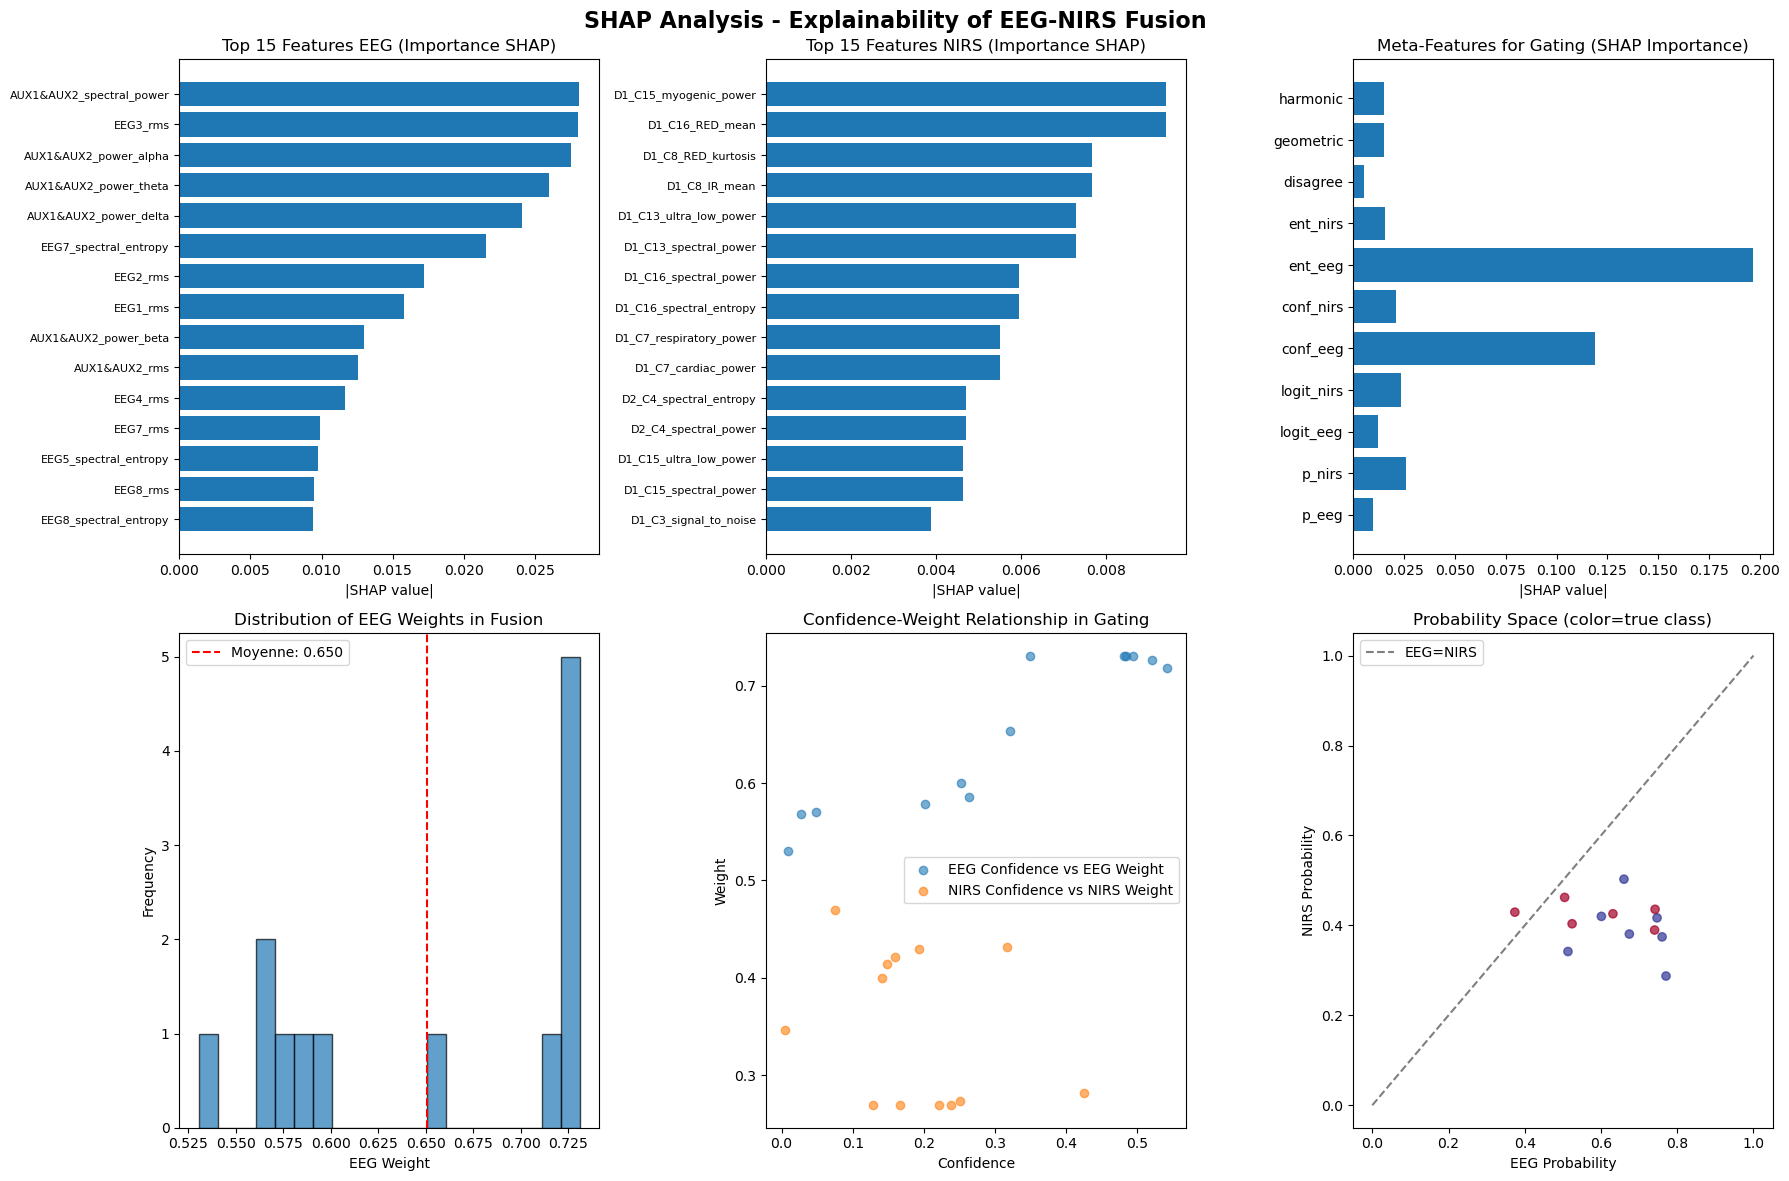


DETAILED EXPLAINABILITY REPORT

🧠 EEG MODEL (SVM):
   • Most important features: AUX1&AUX2_power_delta, AUX1&AUX2_power_theta, AUX1&AUX2_power_alpha, EEG3_rms, AUX1&AUX2_spectral_power
   • Average top-5 importance: 0.0268

🔴 NIRS MODEL (RF):
   • Most important features: D1_C13_ultra_low_power, D1_C8_IR_mean, D1_C8_RED_kurtosis, D1_C16_RED_mean, D1_C15_myogenic_power
   • Average top-5 importance: 0.0083

⚖️ DYNAMIC GATING:
   • Most important meta-feature: ent_eeg
   • Average EEG weight: 0.650 ± 0.076
   • Average NIRS weight: 0.350 ± 0.076

👁️ CLASS ANALYSIS:
   • Average EEG weight (AO): 0.672
   • Average EEG weight (SO): 0.625
   • Difference: 0.048


In [3]:
# =========================
# === EXPLICABILITÉ SHAP ==
# =========================
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

def analyze_shap_explainability(X_eeg, X_nirs, y, n_samples=100):
    """
    Analyse SHAP pour comprendre l'importance des features dans la fusion EEG-NIRS
    """
    print("=== SHAP EXPLAINABILITY ANALYSIS ===\n")
    
    # Split train/test pour l'analyse
    indices = np.arange(len(y))
    tr_idx, te_idx = train_test_split(indices, test_size=0.3, stratify=y, random_state=RANDOM_STATE)
    
    Xe_tr, Xe_te = X_eeg.iloc[tr_idx], X_eeg.iloc[te_idx]
    Xn_tr, Xn_te = X_nirs.iloc[tr_idx], X_nirs.iloc[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]
    
    # 1. SHAP pour les modèles EEG et NIRS individuels
    print("1. Training individual models...")
    
    # Entraînement modèles EEG et NIRS
    eeg_pipe_shap = Pipeline([("scaler", StandardScaler()), ("clf", build_models()[best_eeg_name])])
    nirs_pipe_shap = Pipeline([("scaler", StandardScaler()), ("clf", build_models()[best_nirs_name])])
    
    eeg_pipe_shap.fit(Xe_tr, y_tr)
    nirs_pipe_shap.fit(Xn_tr, y_tr)
    
    # Préparation données pour SHAP (échantillonnage si trop de features)
    n_samples_shap = min(n_samples, len(Xe_te))
    sample_idx = np.random.choice(len(Xe_te), n_samples_shap, replace=False)
    
    Xe_sample = Xe_te.iloc[sample_idx]
    Xn_sample = Xn_te.iloc[sample_idx]
    y_sample = y_te[sample_idx]
    
    # 2. SHAP pour EEG
    print("2. SHAP Analysis - EEG Model...")
    try:
        if best_eeg_name in ['RF', 'XGB']:
            # TreeExplainer pour Random Forest et XGBoost
            eeg_explainer = shap.TreeExplainer(eeg_pipe_shap.named_steps['clf'])
            Xe_scaled = eeg_pipe_shap.named_steps['scaler'].transform(Xe_sample)
            eeg_shap_values = eeg_explainer.shap_values(Xe_scaled)
            if isinstance(eeg_shap_values, list):  # Classification binaire
                eeg_shap_values = eeg_shap_values[1]
            # S'assurer que c'est 2D
            if len(eeg_shap_values.shape) > 2:
                eeg_shap_values = eeg_shap_values.reshape(eeg_shap_values.shape[0], -1)
        else:
            # Explainer générique pour autres modèles
            eeg_explainer = shap.Explainer(eeg_pipe_shap.predict_proba, Xe_tr.sample(min(100, len(Xe_tr))))
            shap_exp = eeg_explainer(Xe_sample, max_evals=500)
            if hasattr(shap_exp, 'values'):
                eeg_shap_values = shap_exp.values
                if len(eeg_shap_values.shape) == 3:
                    eeg_shap_values = eeg_shap_values[:,:,1]
            else:
                eeg_shap_values = shap_exp
    except Exception as e:
        print(f"Erreur SHAP EEG: {e}, utilisation de permutation explainer...")
        # Fallback avec permutation explainer
        eeg_explainer = shap.explainers.Permutation(eeg_pipe_shap.predict_proba, Xe_tr.sample(min(50, len(Xe_tr))))
        eeg_shap_values = eeg_explainer(Xe_sample)
        if hasattr(eeg_shap_values, 'values'):
            eeg_shap_values = eeg_shap_values.values[:,:,1] if len(eeg_shap_values.values.shape) == 3 else eeg_shap_values.values
        
    # Vérifier et corriger la forme des valeurs SHAP EEG
    if len(eeg_shap_values.shape) != 2:
        print(f"Correction forme EEG SHAP: {eeg_shap_values.shape} -> {(eeg_shap_values.shape[0], np.prod(eeg_shap_values.shape[1:]))}")
        eeg_shap_values = eeg_shap_values.reshape(eeg_shap_values.shape[0], -1)
    
    # 3. SHAP pour NIRS
    print("3. SHAP Analysis - NIRS Model...")
    try:
        if best_nirs_name in ['RF', 'XGB']:
            nirs_explainer = shap.TreeExplainer(nirs_pipe_shap.named_steps['clf'])
            Xn_scaled = nirs_pipe_shap.named_steps['scaler'].transform(Xn_sample)
            nirs_shap_values = nirs_explainer.shap_values(Xn_scaled)
            if isinstance(nirs_shap_values, list):
                nirs_shap_values = nirs_shap_values[1]
            # S'assurer que c'est 2D
            if len(nirs_shap_values.shape) > 2:
                nirs_shap_values = nirs_shap_values.reshape(nirs_shap_values.shape[0], -1)
        else:
            # Explainer générique pour autres modèles
            nirs_explainer = shap.Explainer(nirs_pipe_shap.predict_proba, Xn_tr.sample(min(100, len(Xn_tr))))
            shap_exp = nirs_explainer(Xn_sample, max_evals=500)
            if hasattr(shap_exp, 'values'):
                nirs_shap_values = shap_exp.values
                if len(nirs_shap_values.shape) == 3:
                    nirs_shap_values = nirs_shap_values[:,:,1]
            else:
                nirs_shap_values = shap_exp
    except Exception as e:
        print(f"Erreur SHAP NIRS: {e}, utilisation de permutation explainer...")
        nirs_explainer = shap.explainers.Permutation(nirs_pipe_shap.predict_proba, Xn_tr.sample(min(50, len(Xn_tr))))
        nirs_shap_values = nirs_explainer(Xn_sample)
        if hasattr(nirs_shap_values, 'values'):
            nirs_shap_values = nirs_shap_values.values[:,:,1] if len(nirs_shap_values.values.shape) == 3 else nirs_shap_values.values
    
    # Vérifier et corriger la forme des valeurs SHAP NIRS
    if len(nirs_shap_values.shape) != 2:
        print(f"Correction forme NIRS SHAP: {nirs_shap_values.shape} -> {(nirs_shap_values.shape[0], np.prod(nirs_shap_values.shape[1:]))}")
        nirs_shap_values = nirs_shap_values.reshape(nirs_shap_values.shape[0], -1)
    
    # 4. Analyse du modèle de gating
    print("4. SHAP Analysis - Gating Model...")
    
    # Recréer le modèle de gating pour SHAP
    eeg_cal_shap = calibrate_model(eeg_pipe_shap, Xe_tr, y_tr, method="sigmoid")
    nirs_cal_shap = calibrate_model(nirs_pipe_shap, Xn_tr, y_tr, method="sigmoid")
    
    # Probas pour le gating
    p_eeg_tr = eeg_cal_shap.predict_proba(Xe_tr)[:, 1]
    p_nirs_tr = nirs_cal_shap.predict_proba(Xn_tr)[:, 1]
    p_eeg_sample = eeg_cal_shap.predict_proba(Xe_sample)[:, 1]
    p_nirs_sample = nirs_cal_shap.predict_proba(Xn_sample)[:, 1]
    
    # Entraîner le gate
    gate_shap = build_and_fit_gate(p_eeg_tr, p_nirs_tr, y_tr)
    
    # SHAP pour le gate (méta-features)
    X_meta_tr = build_meta_features(p_eeg_tr, p_nirs_tr)
    X_meta_sample = build_meta_features(p_eeg_sample, p_nirs_sample)
    
    # Explainer pour le modèle de gating
    def gate_predict_wrapper(X_meta):
        return gate_shap.predict(X_meta)
    
    try:
        gate_explainer = shap.explainers.Permutation(gate_predict_wrapper, X_meta_tr[:100])
        gate_shap_exp = gate_explainer(X_meta_sample)
        if hasattr(gate_shap_exp, 'values'):
            gate_shap_values = gate_shap_exp.values
        else:
            gate_shap_values = gate_shap_exp
    except Exception as e:
        print(f"Erreur SHAP Gate: {e}, utilisation d'approximation simple...")
        # Approximation simple par perturbation
        gate_shap_values = np.zeros((X_meta_sample.shape[0], X_meta_sample.shape[1]))
        baseline = gate_predict_wrapper(X_meta_tr[:100].mean(axis=0).reshape(1, -1))[0]
        for i in range(X_meta_sample.shape[1]):
            X_perturb = X_meta_sample.copy()
            X_perturb[:, i] = X_meta_tr[:, i].mean()
            pred_perturb = gate_predict_wrapper(X_perturb)
            pred_original = gate_predict_wrapper(X_meta_sample)
            gate_shap_values[:, i] = pred_original - pred_perturb
    
    # Vérifier les dimensions
    print(f"Dimensions - EEG SHAP: {eeg_shap_values.shape}, NIRS SHAP: {nirs_shap_values.shape}, Gate SHAP: {gate_shap_values.shape}")
    
    # S'assurer que les indices correspondent aux features
    if eeg_shap_values.shape[1] != X_eeg.shape[1]:
        print(f"Attention: mismatch EEG features {eeg_shap_values.shape[1]} vs {X_eeg.shape[1]}")
        # Ajuster si nécessaire
        min_features = min(eeg_shap_values.shape[1], X_eeg.shape[1])
        eeg_shap_values = eeg_shap_values[:, :min_features]
        
    if nirs_shap_values.shape[1] != X_nirs.shape[1]:
        print(f"Attention: mismatch NIRS features {nirs_shap_values.shape[1]} vs {X_nirs.shape[1]}")
        min_features = min(nirs_shap_values.shape[1], X_nirs.shape[1])
        nirs_shap_values = nirs_shap_values[:, :min_features]
    
    # 5. Visualisations
    print("5. Generating visualizations...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('SHAP Analysis - Explainability of EEG-NIRS Fusion', fontsize=16, fontweight='bold')
    
    # Top features EEG
    eeg_importance = np.abs(eeg_shap_values).mean(axis=0)
    n_eeg_features = min(15, len(eeg_importance))
    top_eeg_idx = np.argsort(eeg_importance)[-n_eeg_features:]
    top_eeg_names = [X_eeg.columns[i] for i in top_eeg_idx if i < len(X_eeg.columns)]
    
    axes[0,0].barh(range(len(top_eeg_idx)), eeg_importance[top_eeg_idx])
    axes[0,0].set_yticks(range(len(top_eeg_idx)))
    axes[0,0].set_yticklabels([name[:25] + '...' if len(name) > 25 else name for name in top_eeg_names], fontsize=8)
    axes[0,0].set_title(f'Top {n_eeg_features} Features EEG (Importance SHAP)')
    axes[0,0].set_xlabel('|SHAP value|')
    
    # Top features NIRS
    nirs_importance = np.abs(nirs_shap_values).mean(axis=0)
    n_nirs_features = min(15, len(nirs_importance))
    top_nirs_idx = np.argsort(nirs_importance)[-n_nirs_features:]
    top_nirs_names = [X_nirs.columns[i] for i in top_nirs_idx if i < len(X_nirs.columns)]
    
    axes[0,1].barh(range(len(top_nirs_idx)), nirs_importance[top_nirs_idx])
    axes[0,1].set_yticks(range(len(top_nirs_idx)))
    axes[0,1].set_yticklabels([name[:25] + '...' if len(name) > 25 else name for name in top_nirs_names], fontsize=8)
    axes[0,1].set_title(f'Top {n_nirs_features} Features NIRS (Importance SHAP)')
    axes[0,1].set_xlabel('|SHAP value|')
    
    # Importance des méta-features pour le gating
    meta_feature_names = ['p_eeg', 'p_nirs', 'logit_eeg', 'logit_nirs', 'conf_eeg', 'conf_nirs', 
                         'ent_eeg', 'ent_nirs', 'disagree', 'geometric', 'harmonic']
    gate_importance = np.abs(gate_shap_values).mean(axis=0)
    
    axes[0,2].barh(range(len(meta_feature_names)), gate_importance)
    axes[0,2].set_yticks(range(len(meta_feature_names)))
    axes[0,2].set_yticklabels(meta_feature_names)
    axes[0,2].set_title('Meta-Features for Gating (SHAP Importance)')
    axes[0,2].set_xlabel('|SHAP value|')
    
    # Distribution des poids du gate
    weights_eeg = []
    for i in range(len(p_eeg_sample)):
        _, w_eeg = fusion_gating_dynamic(np.array([p_eeg_sample[i]]), np.array([p_nirs_sample[i]]), gate_shap)
        weights_eeg.append(w_eeg[0])
    
    axes[1,0].hist(weights_eeg, bins=20, alpha=0.7, edgecolor='black')
    axes[1,0].axvline(np.mean(weights_eeg), color='red', linestyle='--', label=f'Moyenne: {np.mean(weights_eeg):.3f}')
    axes[1,0].set_title('Distribution of EEG Weights in Fusion')
    axes[1,0].set_xlabel('EEG Weight')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].legend()
    
    # Corrélation entre confiance et poids
    conf_eeg_sample = np.abs(p_eeg_sample - 0.5) * 2
    conf_nirs_sample = np.abs(p_nirs_sample - 0.5) * 2
    
    axes[1,1].scatter(conf_eeg_sample, weights_eeg, alpha=0.6, label='EEG Confidence vs EEG Weight')
    axes[1,1].scatter(conf_nirs_sample, 1-np.array(weights_eeg), alpha=0.6, label='NIRS Confidence vs NIRS Weight')
    axes[1,1].set_xlabel('Confidence')
    axes[1,1].set_ylabel('Weight')
    axes[1,1].set_title('Confidence-Weight Relationship in Gating')
    axes[1,1].legend()
    
    # Comparaison des prédictions
    p_fusion, _ = fusion_gating_dynamic(p_eeg_sample, p_nirs_sample, gate_shap)
    
    axes[1,2].scatter(p_eeg_sample, p_nirs_sample, c=y_sample, cmap='RdYlBu', alpha=0.7)
    axes[1,2].set_xlabel('EEG Probability')
    axes[1,2].set_ylabel('NIRS Probability')
    axes[1,2].set_title('Probability Space (color=true class)')
    
    # Ligne de prédiction égale
    axes[1,2].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='EEG=NIRS')
    axes[1,2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # 6. Rapport textuel détaillé
    print("\n" + "="*80)
    print("DETAILED EXPLAINABILITY REPORT")
    print("="*80)
    
    print(f"\n🧠 EEG MODEL ({best_eeg_name}):")
    print(f"   • Most important features: {', '.join(top_eeg_names[-5:])}")
    print(f"   • Average top-5 importance: {np.mean(eeg_importance[top_eeg_idx[-5:]]):.4f}")
    
    print(f"\n🔴 NIRS MODEL ({best_nirs_name}):")
    print(f"   • Most important features: {', '.join(top_nirs_names[-5:])}")
    print(f"   • Average top-5 importance: {np.mean(nirs_importance[top_nirs_idx[-5:]]):.4f}")
    
    print(f"\n⚖️ DYNAMIC GATING:")
    print(f"   • Most important meta-feature: {meta_feature_names[np.argmax(gate_importance)]}")
    print(f"   • Average EEG weight: {np.mean(weights_eeg):.3f} ± {np.std(weights_eeg):.3f}")
    print(f"   • Average NIRS weight: {1-np.mean(weights_eeg):.3f} ± {np.std(weights_eeg):.3f}")
    
    # Analyse contextuelle
    ao_mask = y_sample == 1  # Eyes open
    so_mask = y_sample == 0  # Eyes closed
    
    if np.sum(ao_mask) > 0 and np.sum(so_mask) > 0:
        print(f"\n👁️ CLASS ANALYSIS:")
        print(f"   • Average EEG weight (AO): {np.mean(np.array(weights_eeg)[ao_mask]):.3f}")
        print(f"   • Average EEG weight (SO): {np.mean(np.array(weights_eeg)[so_mask]):.3f}")
        print(f"   • Difference: {np.mean(np.array(weights_eeg)[ao_mask]) - np.mean(np.array(weights_eeg)[so_mask]):.3f}")
    
    # Retourner les résultats pour analyse ultérieure
    results = {
        'eeg_shap_values': eeg_shap_values,
        'nirs_shap_values': nirs_shap_values,
        'gate_shap_values': gate_shap_values,
        'eeg_importance': eeg_importance,
        'nirs_importance': nirs_importance,
        'gate_importance': gate_importance,
        'weights_eeg': weights_eeg,
        'top_eeg_features': top_eeg_names,
        'top_nirs_features': top_nirs_names,
        'meta_feature_names': meta_feature_names
    }
    
    return results

# Lancer l'analyse SHAP
print("Installation de SHAP si nécessaire...")
try:
    import shap
except ImportError:
    print("SHAP non installé. Installer avec: pip install shap")
    
# Lancement de l'analyse
shap_results = analyze_shap_explainability(X_eeg, X_nirs, y, n_samples=80)